# Heirarchical Agglomerative Clustering
Notebook for HAC exploration and implementation

In [75]:
import os
import numpy as np
import pandas as pd
import gensim as g
import nltk as n
import analyze_text as atxt

BASE_PATH = '/home/trevor/Projects/iot-diff/iot-tc/'
DATA_CNET_PATH = os.path.join(BASE_PATH, 'cnet-classifications.csv')
D2V_WIKI_PATH = os.path.join(BASE_PATH, 'enwiki_dbow/doc2vec.bin')

def tokenize(text):
    stoplist = ['smart', 'device', 'devices', 'product']
    # Remove named entities
    # TODO necessary?
    named_entities = []
    chunked = n.ne_chunk(n.pos_tag(n.word_tokenize(text)))
    for chunk in chunked:
        if type(chunk) == n.tree.Tree:
           ne = ' '.join([token for token, pos in chunk.leaves()])
           text = text.replace(ne, '')
    # Tokenize
    tokens = atxt.tokenize(text)
    tokens = [token for token in tokens if len(token) >= 4]
    tokens = [atxt.get_lemma(token) for token in tokens if atxt.get_lemma(token)]
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stoplist]
    return tokens

In [ ]:
# Load the model and generate the document vectors
model = g.models.doc2vec.Doc2Vec.load(D2V_WIKI_PATH)
df = pd.read_csv(DATA_CNET_PATH)
df['vec'] = 'N/A'
for i, row in df.iterrows():
    text = row['article_content']
    row['vec'] = model.infer_vector(tokenize(text))
vecs = np.array(df['vec'].tolist())

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

link_mat = linkage(vecs, 'average', 'euclidean')

c, coph_dists = cophenet(link_mat, pdist(vecs, 'euclidean'))
c

0.89702583241810419

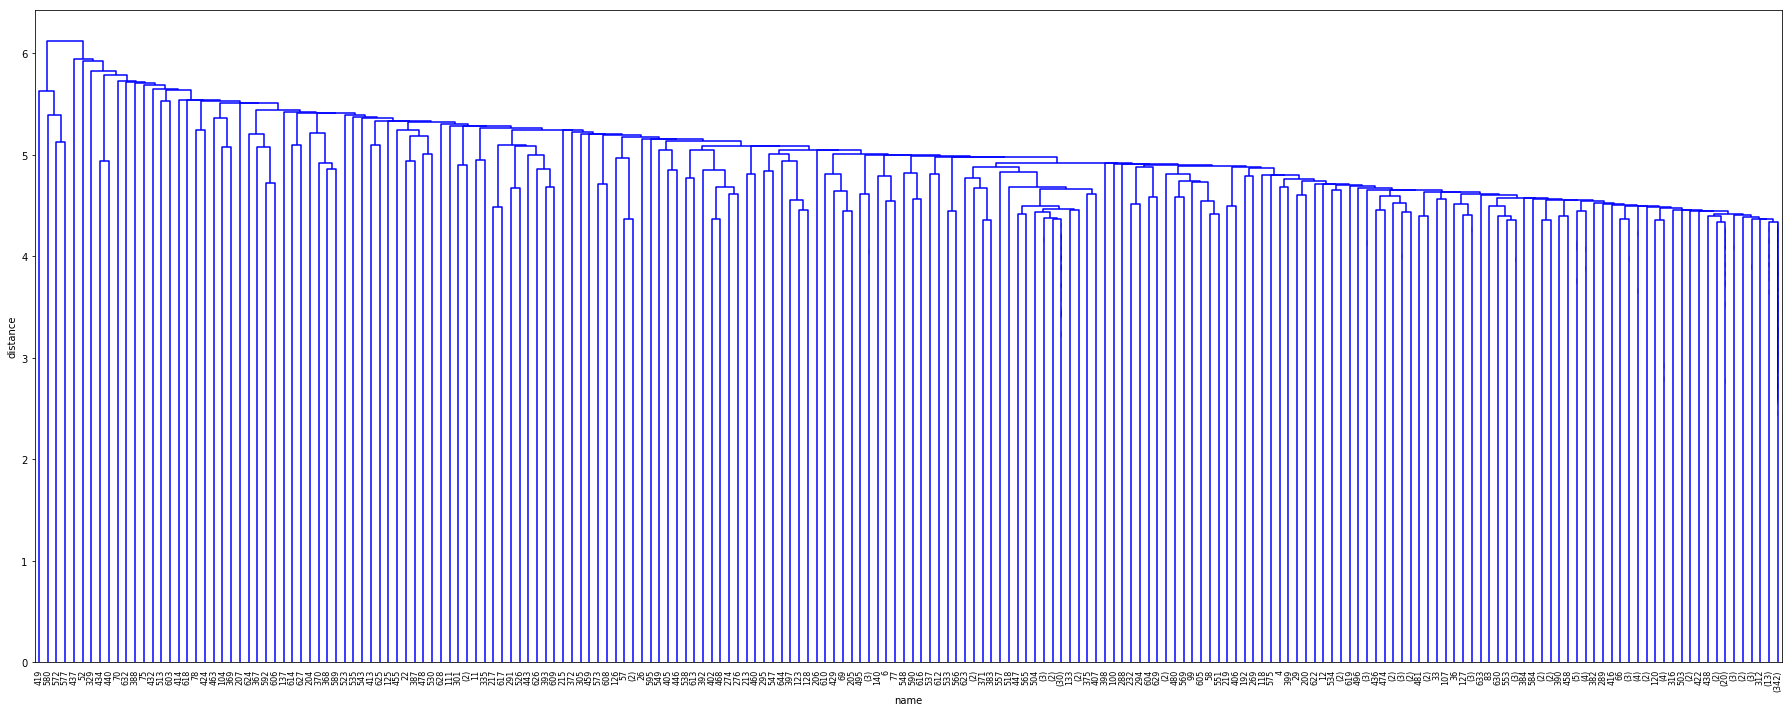

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

plt.figure(figsize=(25, 10))
plt.xlabel('name')
plt.ylabel('distance')
dendrogram(
    link_mat,
    leaf_rotation=90.,
leaf_font_size=8.,
truncate_mode='lastp',
p=200,
show_contracted=True
)
plt.tight_layout()
plt.show()

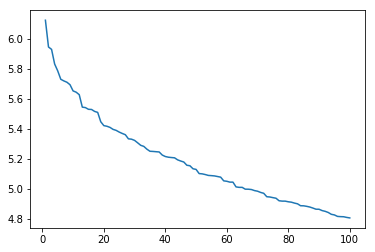

In [70]:
last = link_mat[-100:, 2]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last[::-1])


In [73]:
# Display
from IPython.display import display

df['cluster'] = fcluster(link_mat, 50, 'maxclust')

for i, group in df.groupby('cluster'):
    print('Cluster '+str(i))
    display(group[['device_name', 'device_category']])

Cluster 1


,device_name,device_category
572,"Koubachi Wi-Fi Plant Sensor, Outdoor",garden monitor
577,Parrot Flower Power,garden monitor


Cluster 2


,device_name,device_category
580,Oso Technologies PlantLink,garden monitor


Cluster 3


,device_name,device_category
419,Edyn Garden Sensor,garden monitor


Cluster 4


,device_name,device_category
434,Cree BR30 LED2015,light bulb
440,Ikea 1000L Ledare LED,light bulb


Cluster 5


,device_name,device_category
513,Peq Watchdog,security system


Cluster 6


,device_name,device_category
603,iControl Networks Piper,security system


Cluster 7


,device_name,device_category
78,Loop Labs Notion,house monitor kit


Cluster 8


,device_name,device_category
424,Elgato Eve Room,air quality


Cluster 9


,device_name,device_category
104,Hestan Cue,kitchen
369,Pantelligent,kitchen


Cluster 10


,device_name,device_category
463,Anova Precision Cooker,kitchen


Cluster 11


,device_name,device_category
367,AT&T Digital Life,security system
592,Iris Home Management System,hub
606,SimpliSafe Home Security,security system


Cluster 12


,device_name,device_category
624,Insteon Starter Kit,starter kit


Cluster 13


,device_name,device_category
614,Oplink Security TripleShield,security system
627,iSmartAlarm,security system


Cluster 14


,device_name,device_category
368,Lifx Color 1000 Smart Bulb,light bulb
370,Misfit Bolt Connected Smart Bulb,light bulb
589,LIFX bulb,light bulb


Cluster 15


,device_name,device_category
204,Lifx Plus Wi-Fi LED Smart Bulb,light bulb


Cluster 16


,device_name,device_category
413,Nest Learning Thermostat Third Generation,thermostat
625,Honeywell Wi-Fi Smart Thermostat,thermostat


Cluster 17


,device_name,device_category
22,Vivint Smart Home,security system
387,Korner,security system


Cluster 18


,device_name,device_category
478,iSmartAlarm iCamera Keep,camera
530,D-Link Pan & Tilt Day/Night Network Camera,camera


Cluster 19


,device_name,device_category
455,Canary Smart Home Security Device,security system


Cluster 20


,device_name,device_category
231,Amazon Echo Dot2nd Generation,assistant speaker
301,Amazon Tap,assistant speaker
302,Amazon Echo Dot1st Generation,assistant speaker


Cluster 21


,device_name,device_category
11,Amazon Echo2017,assistant speaker
335,Somfy myLink,shade


Cluster 22


,device_name,device_category
217,Kwikset Kevo 2nd Gen Bluetooth Smart Lock,smart lock
291,August Smart Lock HomeKit Enabled,smart lock
393,GE Z-Wave Plug-In Smart Switch,outlet
443,Chamberlain Wi-Fi Garage Door Opener,garage opener
526,August Smart Lock,smart lock
609,Yale Real Living Touchscreen Z-Wave Deadbolt,smart lock
617,Kwikset Kevo Bluetooth Door Lock,smart lock
626,Schlage Camelot Touchscreen Deadbolt,smart lock


Cluster 23


,device_name,device_category
573,Netatmo Weather Station,weather station
608,Quirky Spotter Multipurpose Sensor,house monitor kit


Cluster 24


,device_name,device_category
28,Blossom Smart Watering Controller,sprinkler
49,Orbit B-hyve,sprinkler
57,Rachio Smart Sprinkler Controller Generation 2,sprinkler
126,U by Moen Smart Shower,shower


Cluster 25


,device_name,device_category
405,SmartThings Hub and Sensors,starter kit
446,Lutron Caséta Wireless Lighting Starter Kit,light bulb
549,Wink Hub,hub


Cluster 26


,device_name,device_category
0,1-Ring Moon,camera
1,Feit Electric 6.5W Vintage Style LED,light bulb
2,Kwikset Obsidian Keywayless Smart Lock,smart lock
3,Honeywell Smart Home Security System,security system
4,Friday Smart Lock,smart lock
5,Noon Smart Lighting Starter Kit,light bulb
6,Amazon Echo Plus,assistant speaker
7,Wink Lookout,security system
8,Lynky,assistant speaker
9,Guardzilla 360,camera


Cluster 27


,device_name,device_category
595,Staples Connect Hub,hub


Cluster 28


,device_name,device_category
26,Samsung RF265BEAESR French Door Family Hub Ref...,refrigerator


Cluster 29


,device_name,device_category
459,Pure Imagination Perfect Drink,kitchen


Cluster 30


,device_name,device_category
305,Kuvée Bottle,kitchen


Cluster 31


,device_name,device_category
372,Hiku Labs Hiku2015,barcode scanner


Cluster 32


,device_name,device_category
215,W Labs by Whirlpool Corporation Zera Food Recy...,kitchen


Cluster 33


,device_name,device_category
111,BloomSky Sky2 Weather Camera Station,weather station


Cluster 34


,device_name,device_category
628,Philips Hue Connected Bulb Starter Pack,light bulb


Cluster 35


,device_name,device_category
125,Petnet SmartFeeder,pet


Cluster 36


,device_name,device_category
543,Quirky Porkfolio,coin tracker


Cluster 37


,device_name,device_category
535,GE Link Connected LED,light bulb


Cluster 38


,device_name,device_category
523,Leeo Smart Alert Nightlight,light bulb


Cluster 39

,device_name,device_category
137,Teforia Infuser,kitchen


Cluster 40

,device_name,device_category
207,Sleep Number it,mattress


Cluster 41


,device_name,device_category
618,Click & Grow Smart Flowerpot,garden monitor


Cluster 42


,device_name,device_category
414,iHome iSP5 SmartPlug,outlet


Cluster 43


,device_name,device_category
432,Finally Light Bulb,light bulb


Cluster 44


,device_name,device_category
75,Amazon Echo Look,assistant speaker


Cluster 45


,device_name,device_category
388,Neato Botvac Connected Robot Vacuum,cleaner


Cluster 46


,device_name,device_category
632,Nest Learning Thermostat,thermostat


Cluster 47


,device_name,device_category
70,Amazon Echo Show,assistant speaker


Cluster 48


,device_name,device_category
329,First Alert OneLink Wi-Fi Smoke and CO Alarm,air hazard


Cluster 49


,device_name,device_category
52,Weber Genesis II E-310,kitchen


Cluster 50


,device_name,device_category
437,Netatmo Welcome,camera
